# Imports 

In [ ]:
! pip install numpy

In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib

In [ ]:
!pip install torch

In [ ]:
!pip install torchvision

In [ ]:
!pip install timm

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
from torch import nn, optim 
from torch.utils.data import Dataset, DataLoader 

from torchvision import transforms as T

import timm

![](Untitled-design.png)

# Configurations

In [2]:
TRAIN_CSV="train.csv"
VALID_CSV="valid.csv"

BATCH_SIZE=128
DEVICE="cpu"

MODEL_NAME="efficientnet_b0"

LR=0.001
EPOCHS=15

In [3]:
df_train=pd.read_csv(TRAIN_CSV)
df_valid=pd.read_csv(VALID_CSV)

df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,labels
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667,Squiggle
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490,Squiggle
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510,Squiggle
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373,Squiggle
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412,Squiggle


In [4]:
print(f"No. of examples present in df_train : {len(df_train)}")
print(f"No. of examples present in df_valid : {len(df_valid)}")
print(f"Labels are : {df_train['labels'].unique()}")

No. of examples present in df_train : 3200
No. of examples present in df_valid : 800
Labels are : ['Squiggle' 'Narrowbanddrd' 'Noises' 'Narrowband']


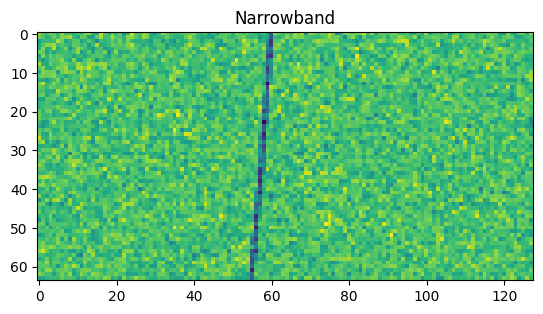

In [5]:
idx=3100

row=df_train.iloc[idx]
image_pixels=np.array(row[:-1],dtype=np.float64)
label=row.labels

image=np.resize(image_pixels,(64,128))  #64*128=8192
plt.imshow(image)
plt.title(label);

# Declare Spec Augmentations 

![](image6.png)

In [6]:
from spec_augment import TimeMask, FreqMask

In [7]:
def get_train_transform():
    return T.Compose([
        TimeMask(T=15, num_masks=4),
        FreqMask(F=15, num_masks=3)  #mask width and num
    ]) 

# Create Custom Dataset 

In [8]:
#give index and return image and label pair
class SpecDataset(Dataset):
    
    def __init__(self, df, augmentations=None):
        self.df=df
        self.augmentations=augmentations
        
        label_mapper={
            "Squiggle":0,
            "Narrowband":1,
            "Narrowbanddrd":2,
            "Noises":3
        }
        
        self.df.loc[:,"labels"]=self.df.labels.map(label_mapper) #substitute text to num
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        
        row=self.df.iloc[idx]
        image_pixels=np.array(row[:-1],dtype=np.float64)
        
        image=np.resize(image_pixels,(64,128,1))
        label=np.array(row.labels,dtype=np.int64)
        
        image=torch.Tensor(image).permute(2,0,1)  #(c,h,w),pytorch image passing convention
        
        if self.augmentations!= None:
            image=self.augmentations(image)
            
        return image.float(), label

In [9]:
trainset=SpecDataset(df_train,get_train_transform())
validset=SpecDataset(df_valid)

0


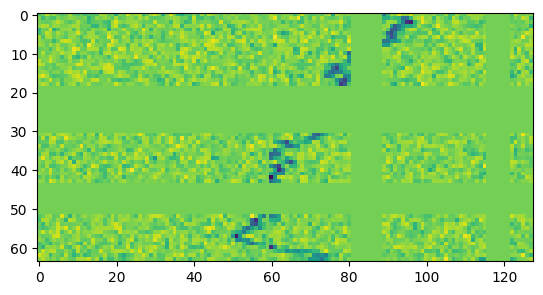

In [10]:
image, label = trainset[8]

plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

# Load dataset into Batches

In [11]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=DataLoader(validset, batch_size=BATCH_SIZE)


In [12]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 25
Total no. of batches in validloader : 7


In [13]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([128, 1, 64, 128])
One label batch shape : torch.Size([128])


# Load Model

In [14]:
#pytorch image models
class SpecModel(nn.Module):
    
    def __init__(self):
        super(SpecModel,self).__init__()
        
        self.net=timm.create_model(MODEL_NAME, num_classes=4, pretrained=True, in_chans=1) 
        
    def forward(self, images, labels=None):
        logits=self.net(images) #raw output without activation
        
        if labels != None:
            loss=nn.CrossEntropyLoss()
            return logits, loss(logits, labels)
        
        return logits
        

In [15]:
model=SpecModel()
model;

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

D:\Python\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\24698\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# Create Train and Eval Function

In [16]:
from tqdm.notebook import tqdm 
from utils import multiclass_accuracy

In [21]:
def train_fn(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss=0.0
    total_acc=0.0
    progress_bar=tqdm(dataloader, desc="EPOCH"+"[TRAIN]"+str(current_epoch+1)+"/"+str(EPOCHS))
    
    for t, data in enumerate(progress_bar):
        images, labels=data
        images, labels=images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss=model(images, labels)
        loss.backward()
        optimizer.step()
        
        total_loss+= loss.item()
        total_acc+= multiclass_accuracy(logits, labels)
        
        temp={'loss': '%6f' %float(total_loss/(t+1)), 'acc':'%6f' %float(total_acc/(t+1))}
        
        progress_bar.set_postfix(temp)
    return total_loss/len(dataloader), total_acc/len(dataloader)
                                                                     

In [22]:
def eval_fn(model, dataloader, current_epoch):
    model.eval()
    total_loss=0.0
    total_acc=0.0
    progress_bar=tqdm(dataloader, desc="EPOCH"+"[VALID]"+str(current_epoch+1)+"/"+str(EPOCHS))
    
    
    with torch.no_grad():
        for t, data in enumerate(progress_bar):
            images, labels=data
            images, labels=images.to(DEVICE), labels.to(DEVICE)

            logits, loss= model(images, labels)

            total_loss+= loss.item()
            total_acc+= multiclass_accuracy(logits, labels)

            temp={'loss': '%6f' %float(total_loss/(t+1)), 'acc':'%6f' %float(total_acc/(t+1))}

            progress_bar.set_postfix(temp)
    return total_loss/len(dataloader), total_acc/len(dataloader)
                                                                   

# Training Loop 

In [23]:
def fit(model,trainloader, validloader, optimizer):
    
    best_valid_loss=np.Inf
    
    for i in range(EPOCHS):
        train_loss, train_acc=train_fn(model, trainloader, optimizer, i)
        valid_loss, valid_acc=eval_fn(model, validloader,i)
        
        if valid_loss< best_valid_loss:
            torch.save(model.state_dict(), MODEL_NAME+"-best-weights.pt")
            print("SAVED-BEST-WEIGHTS")
            
            best_valid_loss=valid_loss

In [24]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)
fit(model, trainloader, validloader, optimizer)

EPOCH[TRAIN]1/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH[VALID]1/15:   0%|          | 0/7 [00:00<?, ?it/s]

UnboundLocalError: cannot access local variable 'total_acc' where it is not associated with a value

# Inference 

In [ ]:
from utils import view_classify